# Modeling done by Song:

In [3]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
#import tensorflow_hub as hub
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

#from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import unicodedata
import random
from sklearn.model_selection import GridSearchCV

from transformers import BertTokenizer, BertModel
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from nltk.tokenize import TweetTokenizer
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv("../data/brand_product_emotion.csv", encoding= 'unicode_escape')

## Cleaning DB

In [4]:
new_col_names = {'tweet_text': 'tweet', 
                 'emotion_in_tweet_is_directed_at':'device', 
                 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}

In [5]:
df = df.rename(columns=new_col_names)

In [6]:
df['emotion'] = df['emotion'].replace("Positive emotion","positive")
df['emotion'] = df['emotion'].replace("Negative emotion","negative")
df['emotion'] = df['emotion'].replace("No emotion toward brand or product","neutral")
df['emotion'] = df['emotion'].replace("I can't tell","unknown")
df['emotion'].value_counts()

neutral     5389
positive    2978
negative     570
unknown      156
Name: emotion, dtype: int64

In [7]:
#creating a feature col
emotion_map = {'neutral': 0, 'positive': 1, 'negative': 2, 'unknown':3}

In [8]:
df['target'] = df['emotion'].map(emotion_map)

In [9]:
df['target'].value_counts()

0    5389
1    2978
2     570
3     156
Name: target, dtype: int64

In [28]:
df.dropna(subset = ['tweet'], inplace = True)

In [29]:
df['tweet'].isna().value_counts()

False    9092
Name: tweet, dtype: int64

## Initial text-preprocessing function

In [30]:
sw = stopwords.words('english')

In [31]:
#following 2 functions taken from class
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [32]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    
    doc = regex_token.tokenize(doc)
    #doc = word_tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

## Making the split-test and applying text-formatter

In [33]:
X = df.tweet
y = df.target

In [34]:
#first split, X_test, and y_test will be FINAL test used on model
# 80% in testing sample
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.20)

In [38]:
# from the 80%, splitting 80-20 again for validation.
# X_valid/y_valid will be used for validation tests
X_train, X_valid, y_train, y_valid = train_test_split(token_docs,
                                                    y_train_temp,
                                                    random_state=42,
                                                    test_size=0.20)

In [35]:
token_docs = [doc_preparer(doc, sw) for doc in X_train_temp]

## Count Vectorizer with 20 feat limit and MNB 

In [36]:
fullpipe = Pipeline([
    ('cv', CountVectorizer(max_features=20)),
    ('mnb', MultinomialNB())
])

In [40]:
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(max_features=20)),
                ('mnb', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.60      0.88      0.72       839
           1       0.48      0.22      0.30       499
           2       0.00      0.00      0.00        94
           3       0.00      0.00      0.00        23

    accuracy                           0.58      1455
   macro avg       0.27      0.27      0.25      1455
weighted avg       0.51      0.58      0.52      1455



F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


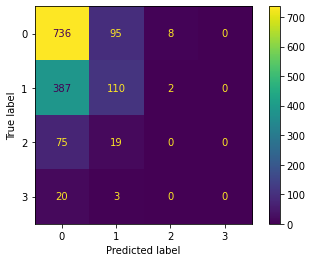

In [41]:
y_pred = fullpipe.predict(X_valid)
#eval model
report = classification_report(y_valid, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

## Count Vectorizer with no feat limit and MNB 

In [42]:
fullpipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       839
           1       0.54      0.51      0.52       499
           2       0.57      0.13      0.21        94
           3       0.00      0.00      0.00        23

    accuracy                           0.64      1455
   macro avg       0.45      0.36      0.37      1455
weighted avg       0.62      0.64      0.61      1455



F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


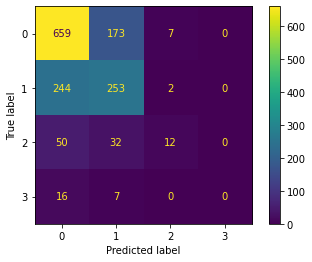

In [43]:
y_pred = fullpipe.predict(X_valid)
#eval model
report = classification_report(y_valid, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Conclusion so far:
- well, slightly better.
- 4 targets is rough. Will drop the 'unknown' feature most likely
    - this prob isnt helping the model


## CV with some more restrictions and MNB

In [44]:
fullpipe = Pipeline([
    ('cv', CountVectorizer(min_df=0.01, max_df=0.99)),
    ('mnb', MultinomialNB())
])
fullpipe.fit(X_train, y_train)


Pipeline(steps=[('cv', CountVectorizer(max_df=0.99, min_df=0.01)),
                ('mnb', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       839
           1       0.50      0.41      0.45       499
           2       0.10      0.06      0.08        94
           3       0.00      0.00      0.00        23

    accuracy                           0.58      1455
   macro avg       0.31      0.31      0.31      1455
weighted avg       0.55      0.58      0.56      1455



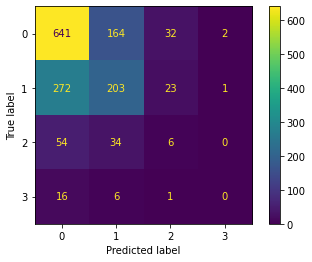

In [45]:
y_pred = fullpipe.predict(X_valid)
#eval model
report = classification_report(y_valid, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Gross it did worse

## TF-IDF instead of CV

In [46]:
fullpipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.62      0.95      0.75       839
           1       0.68      0.21      0.32       499
           2       1.00      0.01      0.02        94
           3       0.00      0.00      0.00        23

    accuracy                           0.62      1455
   macro avg       0.57      0.29      0.27      1455
weighted avg       0.65      0.62      0.54      1455



F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


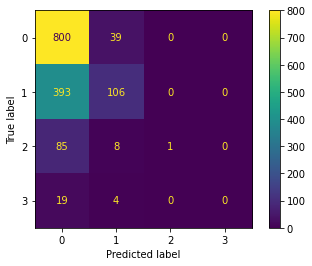

In [47]:
y_pred = fullpipe.predict(X_valid)
#eval model
report = classification_report(y_valid, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Better than previous attempt on cv, but the unlimited feat CV is still best

## Random Forest? With CV

In [54]:
fullpipe = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)),
])
fullpipe.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rfc',
                 RandomForestClassifier(max_depth=5, max_features=5,
                                        n_estimators=1000))])

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       839
           1       0.00      0.00      0.00       499
           2       0.00      0.00      0.00        94
           3       0.00      0.00      0.00        23

    accuracy                           0.58      1455
   macro avg       0.14      0.25      0.18      1455
weighted avg       0.33      0.58      0.42      1455



F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


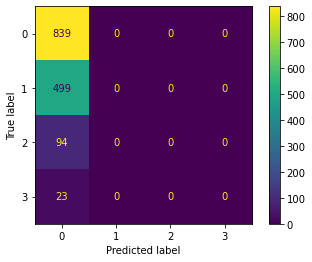

In [55]:
y_pred = fullpipe.predict(X_valid)
#eval model
report = classification_report(y_valid, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

## Conclusion so far:
- oof, rfc did really bad
- also could be because there are too many targets, and target 3 is debatably useless
    - after talking with Scotty we decided target 3 will not be considered from this point forward